# MGH IHP Publication statistics
In this notebook, we will use the data retrieved from OpenAlex to analyze the trends in publications of MGHIHP

To find an institution ID, please...

In [99]:
home_institution = "https://openalex.org/I158133745"
begin = 2010
end = 2023

### Data loading

In [48]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pprint

In [49]:
pip install pyalex

Note: you may need to restart the kernel to use updated packages.


In [50]:
from pyalex import Works, Authors, Sources, Institutions, Concepts, Publishers, Funders

In [102]:
sample = Works().filter(authorships={"institutions": {"id": home_institution}}).sort(publication_year="desc").get()
pprint.pprint(sample)

[{'abstract_inverted_index': None,
  'apc_list': None,
  'apc_paid': None,
  'authorships': [{'author': {'display_name': 'Katrin Tomanek',
                              'id': 'https://openalex.org/A5002347902',
                              'orcid': 'https://orcid.org/0000-0002-9873-7144'},
                   'author_position': 'first',
                   'countries': ['US'],
                   'institutions': [{'country_code': 'US',
                                     'display_name': 'Google (United States)',
                                     'id': 'https://openalex.org/I1291425158',
                                     'lineage': ['https://openalex.org/I1291425158',
                                                 'https://openalex.org/I4210128969'],
                                     'ror': 'https://ror.org/00njsd438',
                                     'type': 'company'}],
                   'is_corresponding': False,
                   'raw_affiliation_string': 'Google Res

 {'abstract_inverted_index': {'(UL)': [16],
                              'Accurate': [48],
                              'Additionally,': [178],
                              'Despite': [87],
                              'Finally,': [214],
                              'In': [113],
                              'Initial': [75],
                              'It': [18],
                              'Potential': [140],
                              'Stroke': [0],
                              'The': [199],
                              'These': [162],
                              'UL': [23, 110],
                              'a': [2, 117, 158],
                              'account': [165],
                              'accuracy': [200],
                              'acute': [39],
                              'additional': [97, 125, 195],
                              'adoption': [151],
                              'advance': [135],
                              'after': [26],


               {'display_name': 'Dystonia',
                'id': 'https://openalex.org/C2778559928',
                'level': 2,
                'score': 0.74257797,
                'wikidata': 'https://www.wikidata.org/wiki/Q906492'},
               {'display_name': 'Medicine',
                'id': 'https://openalex.org/C71924100',
                'level': 0,
                'score': 0.44246122,
                'wikidata': 'https://www.wikidata.org/wiki/Q11190'},
               {'display_name': 'Internal medicine',
                'id': 'https://openalex.org/C126322002',
                'level': 1,
                'score': 0.18507496,
                'wikidata': 'https://www.wikidata.org/wiki/Q11180'},
               {'display_name': 'Psychiatry',
                'id': 'https://openalex.org/C118552586',
                'level': 1,
                'score': 0.1369862,
                'wikidata': 'https://www.wikidata.org/wiki/Q7867'},
               {'display_name': 'Disease',
       

In [103]:
pager = Works().filter(authorships={"institutions": {"id": home_institution}}).sort(publication_year="desc").paginate(per_page=200)
pages = []
for page in pager:
    print(len(page), "additional entries collected...")
    pages = pages + page
print(len(pages), "total entries")
data = pages

200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
200 additional entries collected...
0 additional entries collected...
3000 total entries


Saving a local copy of the database

In [113]:
# The filename where you want to save the JSON data
filename = 'IHP2024.json'

# Saving the list of dictionaries as a JSON file
with open(filename, 'w') as file:
    json.dump(pages, file, indent=4)

print(f'Data saved to {filename}')

Data saved to IHP2024.json


plotting code

In [54]:
def plot_publications_with_dynamic_sizing(publications_data, begin, end, title="Publications"):
    # Filter publications within the specified time window
    filtered_publications = {year: count for year, count in publications_data.items() if begin <= year <= end}
    
    # Sort the dictionary by year
    years = sorted(filtered_publications.keys())
    counts = [filtered_publications[year] for year in years]
    
    # Calculate year-to-year percentage increase
    percentage_increases = [0]  # No increase for the first year
    for i in range(1, len(years)):
        if counts[i-1] == 0:  # Avoid division by zero
            increase = 0
        else:
            increase = ((counts[i] - counts[i-1]) / counts[i-1]) * 100
        percentage_increases.append(increase)
    
    # Determine the size of the plot based on the number of years to display
    width_per_year = 1  # Assumed width per year for readability
    fig_width = max(len(years) * width_per_year, 8)  # Ensure a minimum width for very short ranges
    fig_height = 6  # Fixed height

    fig, ax1 = plt.subplots(figsize=(fig_width, fig_height))

    # Plot histogram of publications per year
    bars = ax1.bar(years, counts, color='b', alpha=0.6, label='Publications per Year')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Publications', color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    # Annotate the bars with the percentage increases
    for bar, increase in zip(bars, percentage_increases):
        ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{increase:+.1f}%', ha='center', va='bottom')

    # Title and legend
    plt.title(title + ' per Year and Year-to-Year Increase in Percentage')
    fig.tight_layout()
    #fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))

    plt.show()

## First of all, let us compute the volume of publication per year and the percentage increase in publication volume per year

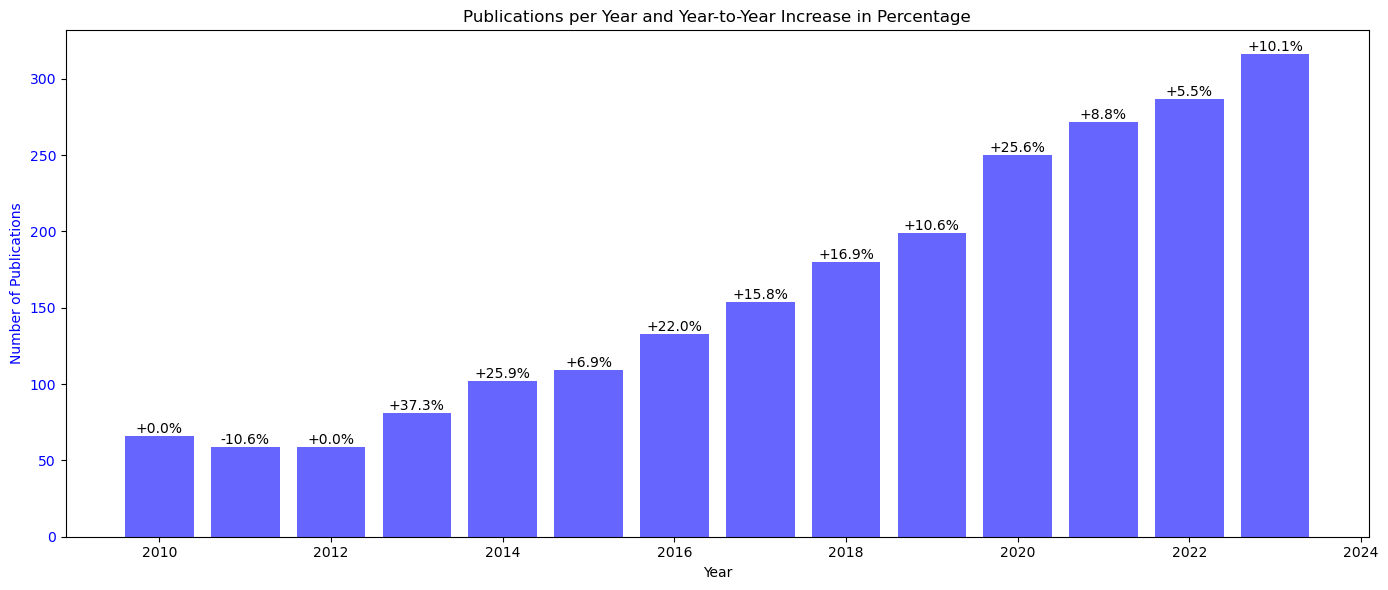

In [104]:
# Count the number of publications per year
publications_per_year = {}
for item in data:
    year = item.get('publication_year')
    if year in publications_per_year:
        publications_per_year[year] += 1
    else:
        publications_per_year[year] = 1

plot_publications_with_dynamic_sizing(publications_per_year, begin, end)

## We now compute the number of collaborations with authors from a different institution per year 

As the sum of authors affiliated with another institution appearing on our publications

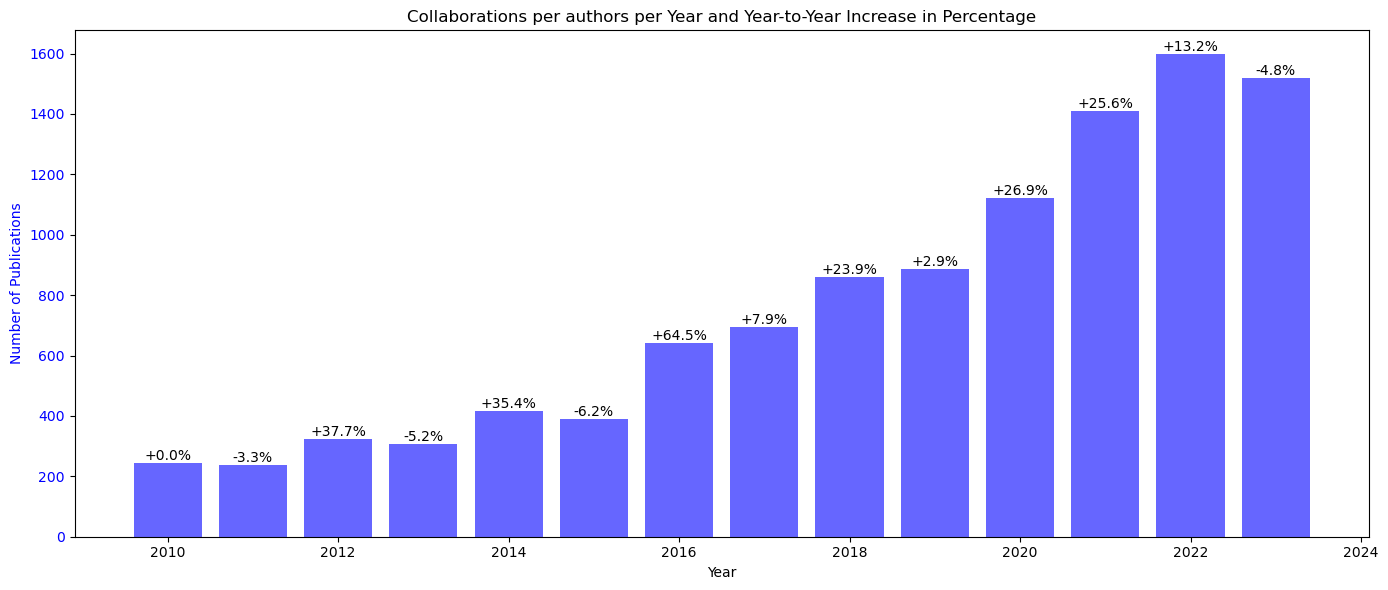

In [105]:
def count_authors_excluding_institution_all_years(data, excluded_institution_id):
    author_counts_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        count = 0
        for authorship in publication.get('authorships', []):
            # Check if author is affiliated with the excluded institution
            affiliated_with_excluded = any(
                excluded_institution_id in institution['id'] for institution in authorship.get('institutions', []))
            if not affiliated_with_excluded:
                count += 1
        
        if year in author_counts_by_year:
            author_counts_by_year[year] += count
        else:
            author_counts_by_year[year] = count

    return author_counts_by_year

# Count authors not affiliated with the specified institution for all publications in the dataset
author_counts_excluding_institution = count_authors_excluding_institution_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(author_counts_excluding_institution, begin, end, "Collaborations per authors")


## Number of different instiutions collaborated with per year

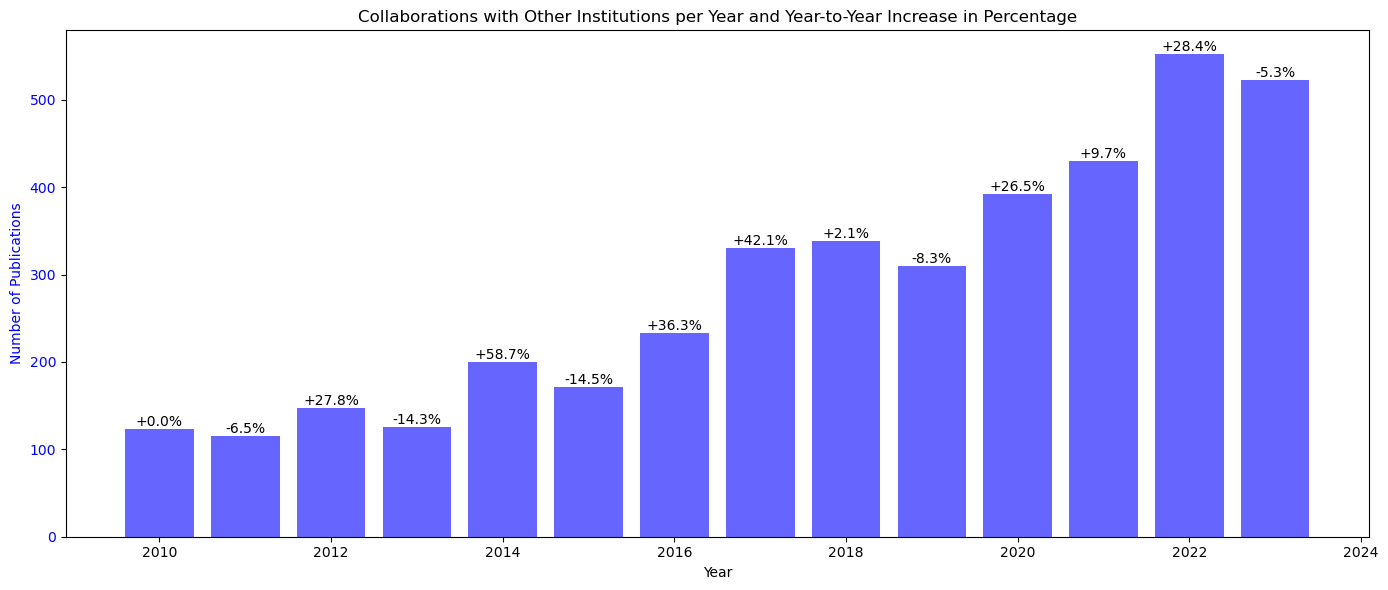

In [106]:
def count_unique_collaborating_institutions_all_years(data, excluded_institution_id):
    unique_institutions_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        unique_institutions = set()

        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                if institution['id'] != excluded_institution_id:
                    unique_institutions.add(institution['id'])

        if year in unique_institutions_by_year:
            unique_institutions_by_year[year].update(unique_institutions)
        else:
            unique_institutions_by_year[year] = unique_institutions

    # Convert sets to counts
    collaborating_institution_counts = {year: len(institutions) for year, institutions in unique_institutions_by_year.items()}

    return collaborating_institution_counts

# Count unique collaborating institutions per year, excluding a specific institution
collaborating_institutions_counts = count_unique_collaborating_institutions_all_years(data, excluded_institution_id)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_institutions_counts, begin, end, "Collaborations with Other Institutions")


## Number of different foreign countries collaborated with per year

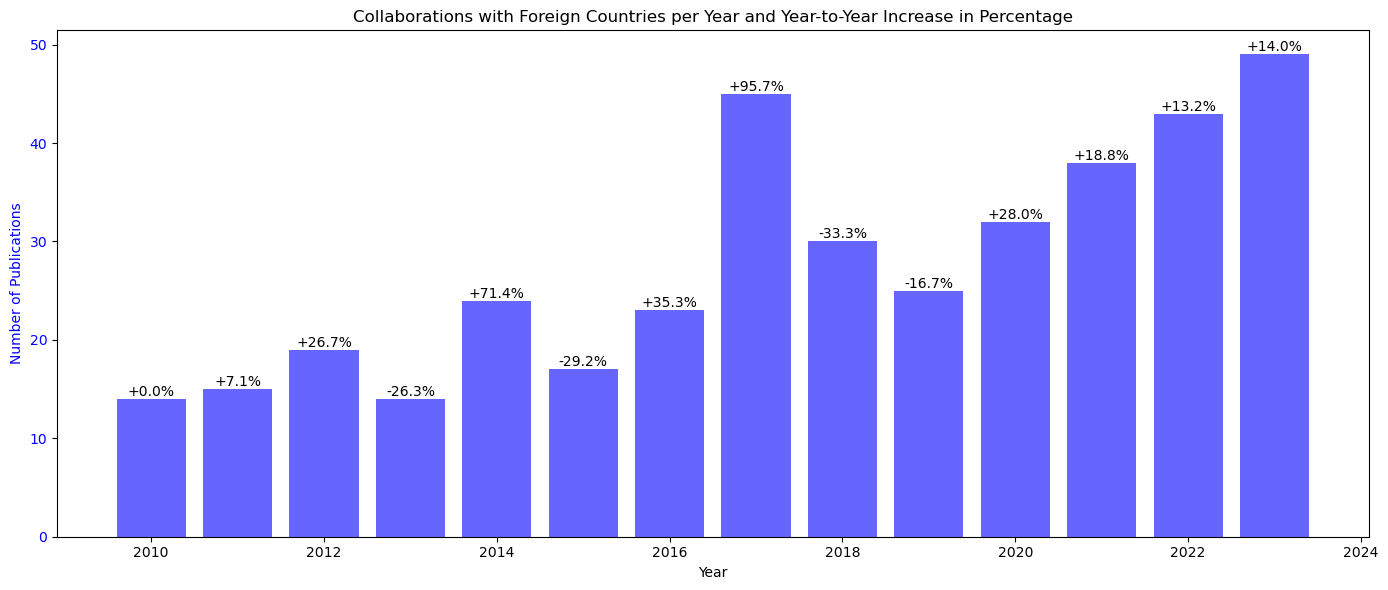

In [107]:
def count_unique_collaborating_countries_all_years(data, excluded_institution_id):
    unique_countries_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        unique_countries = set()

        for authorship in publication.get('authorships', []):
            for institution in authorship.get('institutions', []):
                # Only consider institutions other than the excluded one
                if institution['id'] != excluded_institution_id:
                    # Add the country of the institution, if available
                    country_code = institution.get('country_code')
                    if country_code:
                        unique_countries.add(country_code)

        if year in unique_countries_by_year:
            unique_countries_by_year[year].update(unique_countries)
        else:
            unique_countries_by_year[year] = unique_countries

    # Convert sets to counts
    collaborating_country_counts = {year: len(countries) for year, countries in unique_countries_by_year.items()}

    return collaborating_country_counts

# Count unique collaborating countries per year, excluding a specific institution
collaborating_countries_counts = count_unique_collaborating_countries_all_years(data, excluded_institution_id)

# Plotting the result
plot_publications_with_dynamic_sizing(collaborating_countries_counts, begin, end, "Collaborations with Foreign Countries")


## Number of different publication venues, journals, etc per year

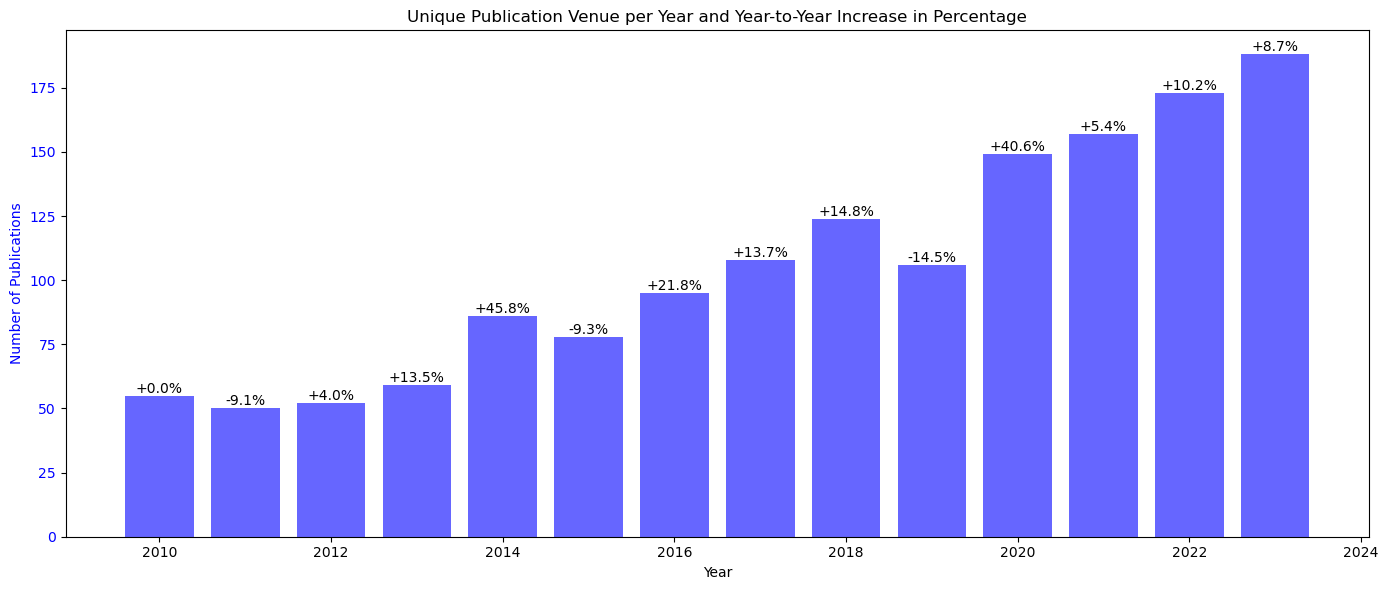

In [108]:
def count_unique_venues_all_years_corrected(data):
    unique_venues_by_year = {}

    for publication in data:
        year = publication.get('publication_year')
        # Ensure 'primary_location' is a dictionary and 'source' is not None before accessing 'id'
        primary_location = publication.get('primary_location', {})
        source = primary_location.get('source') if isinstance(primary_location, dict) else None
        venue_id = source.get('id') if source else None

        if venue_id:  # Only consider publications with a known venue
            if year in unique_venues_by_year:
                unique_venues_by_year[year].add(venue_id)
            else:
                unique_venues_by_year[year] = {venue_id}

    # Convert sets to counts
    unique_venue_counts = {year: len(venues) for year, venues in unique_venues_by_year.items()}

    return unique_venue_counts


# Count unique venues per year with the fixed function
unique_venues_counts_fixed = count_unique_venues_all_years_corrected(data)

# Plotting the result with the fixed data
plot_publications_with_dynamic_sizing(unique_venues_counts_fixed, begin, end, "Unique Publication Venue")


## Number of first authorships per year

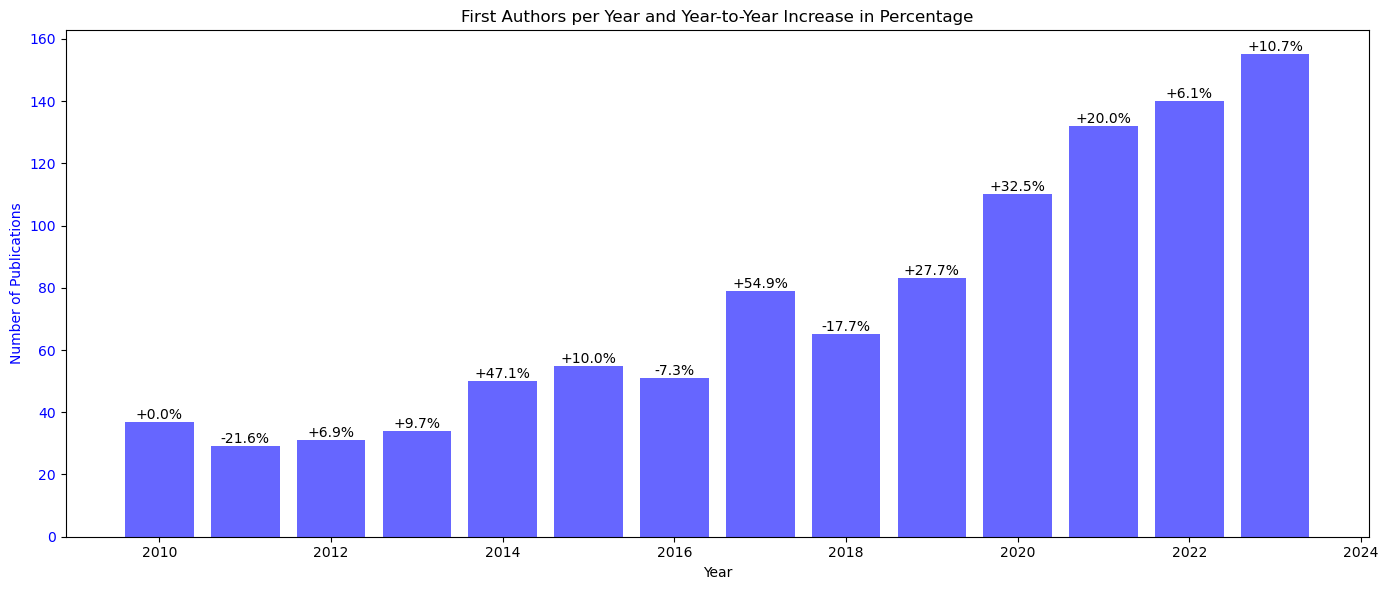

In [109]:
def count_first_author_affiliation_all_years(data, home_institution_id):
    first_author_affiliation_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        for authorship in publication.get('authorships', []):
            if authorship.get('author_position') == 'first':
                # Check if the first author is affiliated with the home institution
                affiliated_with_home = any(
                    home_institution_id == institution['id'] for institution in authorship.get('institutions', []))
                if affiliated_with_home:
                    if year in first_author_affiliation_counts:
                        first_author_affiliation_counts[year] += 1
                    else:
                        first_author_affiliation_counts[year] = 1
                break  # Only consider the first author, so break after checking

    return first_author_affiliation_counts

# Count publications where the first author is affiliated with the home institution per year
first_author_affiliation_counts = count_first_author_affiliation_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(first_author_affiliation_counts, begin, end, "First Authors")


## Number of last authorships per year

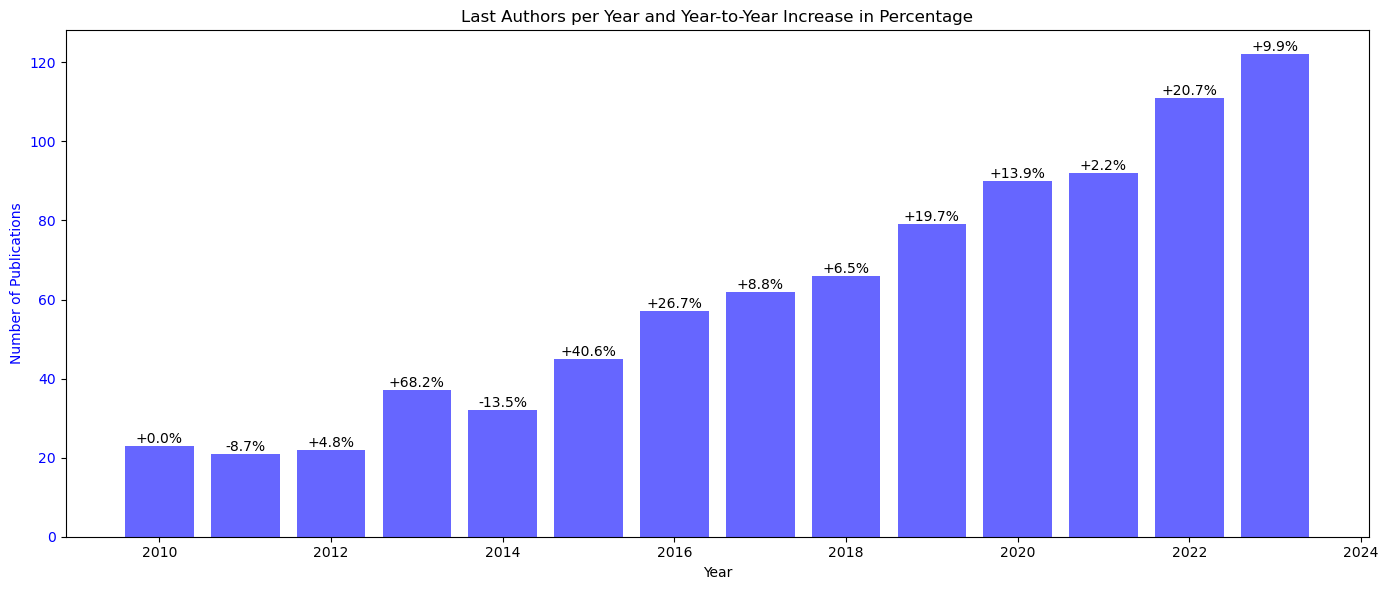

In [110]:
def count_first_author_affiliation_all_years(data, home_institution_id):
    first_author_affiliation_counts = {}

    for publication in data:
        year = publication.get('publication_year')
        for authorship in publication.get('authorships', []):
            if authorship.get('author_position') == 'last':
                # Check if the first author is affiliated with the home institution
                affiliated_with_home = home_institution_id in [institution['id'] for institution in authorship.get('institutions', [])]
                if affiliated_with_home:
                    if year in first_author_affiliation_counts:
                        first_author_affiliation_counts[year] += 1
                    else:
                        first_author_affiliation_counts[year] = 1

    return first_author_affiliation_counts

# Count publications where the first author is affiliated with the home institution per year
last_author_affiliation_counts = count_first_author_affiliation_all_years(data, home_institution)

# Plotting the result
plot_publications_with_dynamic_sizing(last_author_affiliation_counts, begin, end, "Last Authors")

## Number of citations attributed to the year's papers per year, to date

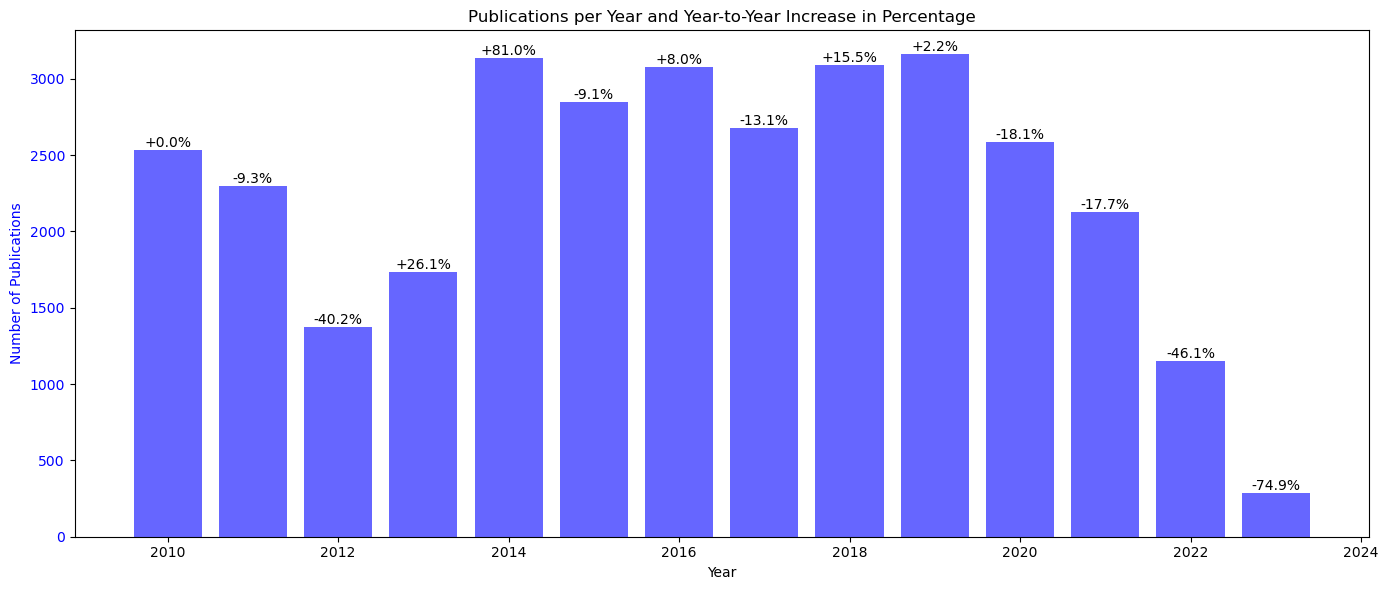

In [112]:
def count_citations_per_year(data):
    citations_per_year = {}

    for publication in data:
        year = publication.get('publication_year')
        citations_count = publication.get('cited_by_count', 0)

        if year in citations_per_year:
            citations_per_year[year] += citations_count
        else:
            citations_per_year[year] = citations_count

    return citations_per_year

# Count the total number of citations accumulated by publications in each year
citations_counts_per_year = count_citations_per_year(data)

# Plotting the result
plot_publications_with_dynamic_sizing(citations_counts_per_year, begin, end)
